# Can overconfidence be eliminated by reserving a portion of the training data to only be optimized for the distribution parameters $\sigma$ and $\alpha$, and unseen by $\mu$?
Specifically, train everything on a large portion of the training data, then forecast the mean of the unseen training data, and train the skewness and variance on that portion.

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import *
from model_objs import *
import vanilla_benchmark

## Pinball Loss

In [4]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

## Vanilla Benchmark Forecast

In [6]:
pre_length = 3 * 365 * 24 // 12  # 3 months
min_train_start = 9 * 365 * 24 + 2 * 24 - pre_length  # 2 leap years from 2005 to 2014
train_starts = np.linspace(min_train_start, min_train_start + 24 * 365 - 24, 12, endpoint=False).astype(int)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [7]:
print(list(train_starts))

[76698, 77426, 78154, 78882, 79610, 80338, 81066, 81794, 82522, 83250, 83978, 84706]


In [8]:
zone_name = "ISONE CA"

In [9]:
vanilla_losses = [397.54593426786477, 604.6018135096928, 329.1556644285198, 197.8631423987858, 323.53210964925717, 415.8909833353536, 544.7284618154562, 540.057213205938, 570.237691916539, 181.8698616921875, 262.12280478463936, 471.97246124553413]
# vanilla_losses = []
# for month in range(1, len(months) + 1):
#     print(months[month-1])
#     vanilla_losses.append(vanilla_benchmark.get_lossesGEFCom(10, 31 * 24, start_date=pd.Timestamp(f"2005-{month}-01"), zones=["ISONE CA"],
#                               delay_days=0, temp_years=np.arange(2005, 2015), plot=True)["ISONE CA"])

In [10]:
for i, loss in list(enumerate(vanilla_losses))[::2]:
    print(np.round(loss, 1), end="\t")

397.5	329.2	323.5	544.7	570.2	262.1	

In [11]:
import json

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))

In [12]:
# rescale data
x_original = data
mean = np.mean(data, axis=0)
rnge = np.max(data, axis=0) - np.min(data, axis=0)
data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
print("data", data.shape)

data (96408, 1)


# Forecasting mean, variance, and skewness of Skew-Normal distribution

In [13]:
%matplotlib inline
z_scores = []
test_z_scores = []
losses = []
relative_perfs = []

TRAIN START: 76698 = 2013-10-01 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: 1.1965277295391723
Loss at iteration 60: -1.5903913795687794
Loss at iteration 110: -1.902132753218703
Loss at iteration 160: -1.9716081842847661
Loss at iteration 210: -2.020580223656382
Loss at iteration 260: -2.0586516736806533
Loss at iteration 310: -2.0822073561925847
Loss at iteration 360: -2.1024546085123097
Loss at iteration 410: -2.12507315919357
Loss at iteration 460: -2.140629386675801
Loss at iteration 510: -2.15791482286589
Loss at iteration 560: -2.1771866937841833
Final loss: -2.1896139433345643


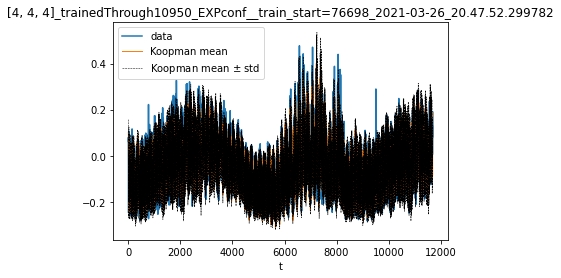

actual overall mean: 0  predicted mean: -0.02014419


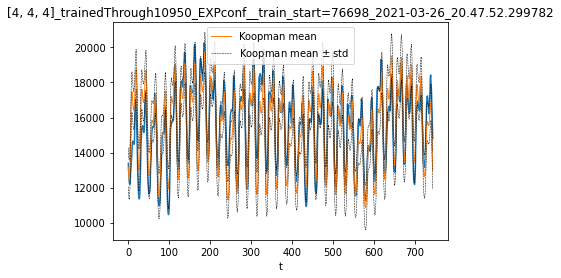

pinball_loss: 310.2421188712203
21.96068626822366% performance relative to vanilla benchmark





TRAIN START: 78154 = 2013-12-01 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: 1.0407426152815955
Loss at iteration 60: -1.5431325702387206
Loss at iteration 110: -1.8629502560524267
Loss at iteration 160: -1.950174638269116
Loss at iteration 210: -2.001552391461864
Loss at iteration 260: -2.037873673255623
Loss at iteration 310: -2.0590013791835506
Loss at iteration 360: -2.083812245210406
Loss at iteration 410: -2.0986933759928097
Loss at iteration 460: -2.1122942412238586
Loss at iteration 510: -2.1251848492555947
Loss at iteration 560: -2.1453303576835117
Final loss: -2.154671297203328


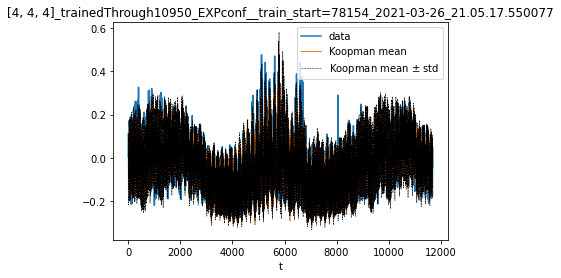

actual overall mean: 0  predicted mean: -0.0033959793


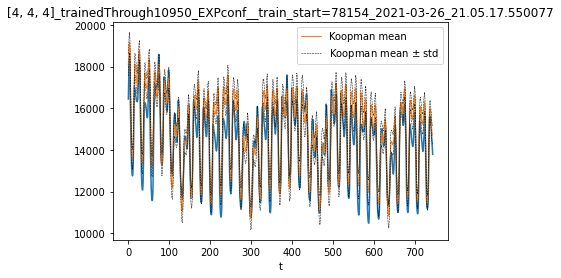

pinball_loss: 270.8502529269421
17.713628475088694% performance relative to vanilla benchmark





TRAIN START: 79610 = 2014-01-31 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: 1.5494364309392956
Loss at iteration 60: -1.4761356673121702
Loss at iteration 110: -1.9546687714434523
Loss at iteration 160: -2.0227264370630427
Loss at iteration 210: -2.068654161476866
Loss at iteration 260: -2.101345259400793
Loss at iteration 310: -2.129377920376696
USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



Loss at iteration 360: -2.1516791238812276
USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR T

USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




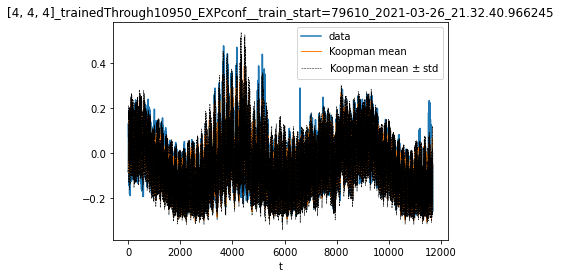

actual overall mean: 0  predicted mean: -0.016305333


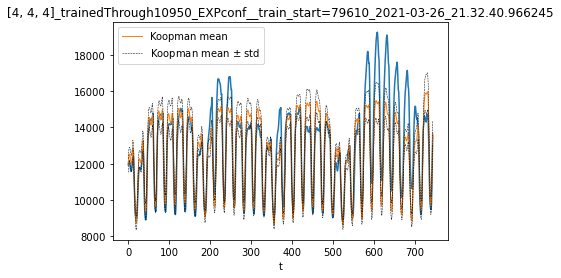

pinball_loss: 333.0098353697048
-2.9294544305733528% performance relative to vanilla benchmark





TRAIN START: 81066 = 2014-04-01 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: 1.3598513899870281
Loss at iteration 60: -1.4213851934756407
USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOA

USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




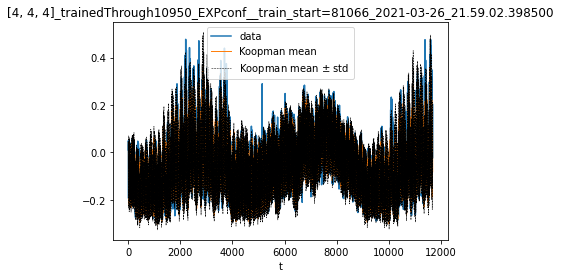

actual overall mean: 0  predicted mean: -0.027286893


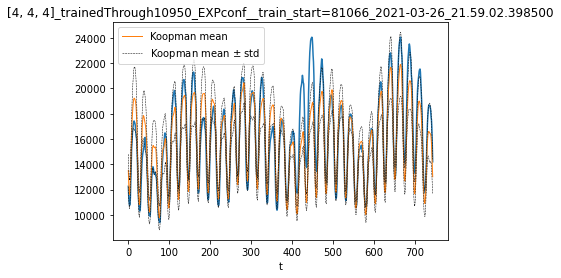

pinball_loss: 423.3784444392036
22.27715749821857% performance relative to vanilla benchmark





TRAIN START: 82522 = 2014-06-01 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: 1.219263629341922
Loss at iteration 60: -1.3304449763769117
Loss at iteration 110: -1.7708666502791826
Loss at iteration 160: -1.8358869612221405
Loss at iteration 210: -1.8805057130239395
USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



Loss at iteration 260: -1.915131974851036
USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH

USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




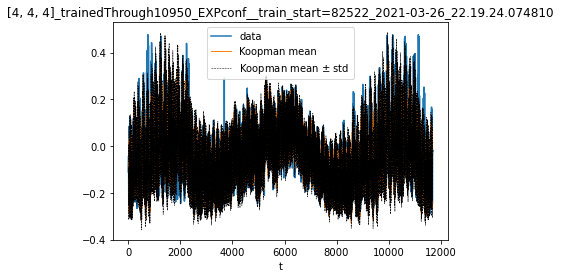

actual overall mean: 0  predicted mean: -0.005211956


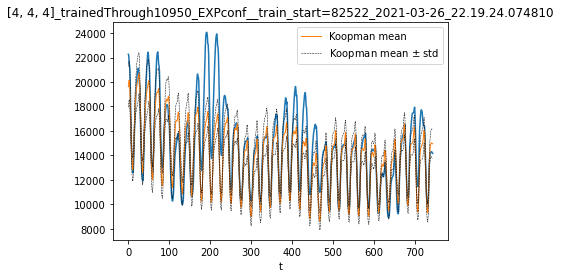

pinball_loss: 527.8452591775116
7.434168828186127% performance relative to vanilla benchmark





TRAIN START: 83978 = 2014-08-01 00:00:00
x (11694, 1)
xt (10950, 1)
Loss at iteration 10: 0.8574992047410633
Loss at iteration 60: -1.4875252438371471
USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATI

USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS



USING LOG CDF APPROXIMATION FOR THIS BATCH TO AVOID FLOATING POINT ERRORS




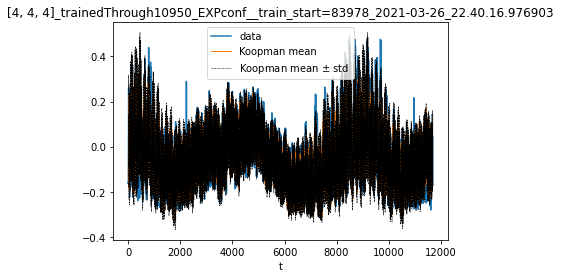

actual overall mean: 0  predicted mean: -0.012030982


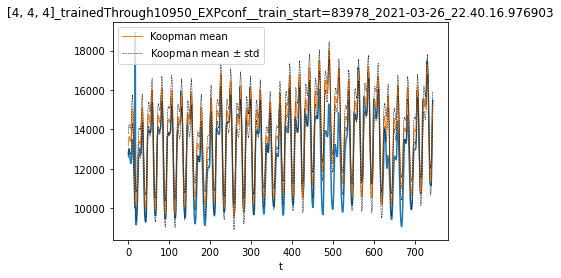

pinball_loss: 347.4210250308004
-32.54131982764426% performance relative to vanilla benchmark







In [14]:
for month, train_start in list(enumerate(train_starts))[::2]:
    print("TRAIN START:", train_start, "=", all_data[zone_name]["Date"][train_start])
    
    train_through = 365 * 24 + pre_length
    delay = 0  # 52 * 24
    predict_through = train_through + 24 * 31 + delay  
    x = data[train_start:]
    x = x[:predict_through]
    xt = x[:train_through]
    mask = torch.ones(xt.shape, dtype=torch.uint8)
    mask[:pre_length] = 0
    num_freqs = [4, 4, 4]
    num_fourier = 4
    loss_weights = 1 + 0.4 * torch.cos(torch.linspace(-2 * np.pi * pre_length / xt.shape[0], 2 * np.pi, xt.shape[0]))
    print("x", x.shape)
    print("xt", xt.shape)
    
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "EXPconf_" + f"_train_start={train_start}_" + now

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)
    
    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
    
    k.fit(xt, iterations=600, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask);

    fname = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"    

    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params
    
    mean_hat = model.mean(params)
    std_hat = model.std(params)
    
    # ADD TO CORRECT BIAS                                                    
    adjust = np.mean((xt - mean_hat[:train_through]) / std_hat[:train_through]) / (np.mean(1 / std_hat[:train_through]))
    mu_hat += adjust
    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / (1 + ah ** 2) ** 0.5
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[month]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

# Figures

In [15]:
# for tables
for loss in losses[:6]:
    print(np.round(loss, 1), end="\t")
print("")
for rel in relative_perfs[:6]:
    print(np.round(rel, 1), end="%\t")

310.2	270.9	333.0	423.4	527.8	347.4	
22.0%	17.7%	-2.9%	22.3%	7.4%	-32.5%	

In [16]:
idx = 6
for z_score in z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")

0.0	0.0	0.0	0.0	0.0	-0.0	
0.96	0.98	0.95	0.98	0.96	0.96	
0.66	0.58	0.37	0.39	0.34	0.45	
0.02	-1.03	0.5	0.28	0.84	-1.31	
0.86	1.26	2.05	1.23	1.7	1.55	
-0.34	-0.09	0.92	1.17	1.0	-0.41	

In [17]:
z_scores = np.array(z_scores)
test_z_scores = np.array(test_z_scores)
losses = np.array(losses)
relative = np.array(relative_perfs)

In [18]:
np.save("experiments\\" + data_name + "z_scores.npy", z_scores)
np.save("experiments\\" + data_name + "test_z_scores.npy", test_z_scores)
np.save("experiments\\" + data_name + "relative_perfs.npy", relative_perfs)
np.save("experiments\\" + data_name + "losses.npy", losses)

Text(0, 0.5, 'standardized residual $z$')

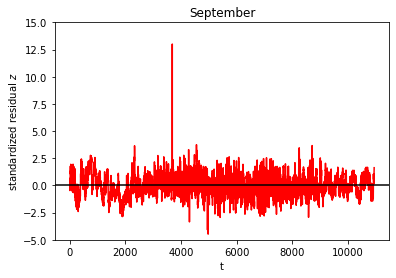

In [19]:
plt.plot(z_scores[4], color="r")
plt.title("September")
plt.axhline(0, color="k")
plt.xlabel("t")
plt.ylim([-5, 15])
plt.ylabel("standardized residual $z$")

In [96]:
zs = (xt - mu_hat[:train_through]) / sigma_hat[:train_through]

In [97]:
b = np.mean(zs)

In [98]:
a = b / (np.mean(1 / sigma_hat[:train_through]))

In [99]:
a

0.03618646150443811

In [100]:
zsc = (xt - (mu_hat[:train_through] + a)) / sigma_hat[:train_through]

In [101]:
zsc.mean()

1.130180568147571e-07